### Importing Required Libraries

- **Data Manipulation & Cleaning:**
  - `pandas` for handling structured data in DataFrames.
  - `numpy` for numerical operations and array handling.
  - `re` for regular expressions, useful for cleaning string data.

- **Data Visualization:**
  - `matplotlib.pyplot` and `seaborn` for creating static and statistical plots to visualize data distributions and relationships.

- **Machine Learning:**
  - `train_test_split` to split data into training and testing sets.
  - `GridSearchCV` for hyperparameter tuning with cross-validation.
  - `OneHotEncoder` to convert categorical variables into binary indicator variables.
  - `FunctionTransformer` for applying custom transformations within pipelines.
  - `ColumnTransformer` to apply different preprocessing steps to different columns.
  - `Pipeline` to chain preprocessing and modeling steps seamlessly.
  - Regression models: `RandomForestRegressor`, `GradientBoostingRegressor`, and `LinearRegression` for predicting continuous outcomes.

- **Model Evaluation:**
  - Metrics such as `mean_absolute_error`, `mean_squared_error`, and `r2_score` to evaluate model performance.

- **Model Persistence:**
  - `joblib` to save and load trained models for reuse.

These imports set up a comprehensive environment for data analysis, preprocessing, modeling, evaluation, and saving results.


In [18]:
# ====================================
# 1. Import Libraries
# ====================================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

### Data Loading and Initial Cleaning

- **Package Installation:**
  - Installs `openpyxl` to enable reading Excel files (`.xlsx` format) with pandas.

- **Loading the Dataset:**
  - Reads the Excel file `"idea_export_voter_turnout_database_region.xlsx"` from the `"All"` sheet into a pandas DataFrame `df`.

- **Cleaning Numeric Fields:**
  - Defines a helper function `clean_numeric` that:
    - Removes commas from numbers formatted as strings (e.g., "1,234").
    - Converts percentages (e.g., "65%") to decimal format (0.65).
    - Converts all cleaned values to floats.
    - Converts invalid or missing values to `NaN`.
  - Applies this function to several important columns such as voter turnout, registration, population, etc.

- **Handling Missing Data:**
  - Drops rows where the target variable `Voter Turnout` is missing (`NaN`) to ensure the dataset only contains complete cases for modeling.

- **Processing Date and Binary Features:**
  - Converts the `Year` column to datetime and extracts only the year as an integer.
  - Creates a binary column `Compulsory Voting` based on whether the original `Compulsory voting` column equals `"Yes"` (1 if yes, else 0).

This step prepares the raw dataset for analysis by ensuring numeric data are correctly formatted, missing values are handled, and relevant features are properly typed.


In [19]:
%pip install openpyxl

# ====================================
# 2. Load and Initial Cleaning
# ====================================
file_path = "idea_export_voter_turnout_database_region.xlsx"  # Adjust if needed
df = pd.read_excel(file_path, sheet_name="All")

# Clean numeric fields
def clean_numeric(x):
    if pd.isna(x):
        return np.nan
    x = re.sub(r',', '', str(x))
    if '%' in x:
        return float(x.replace('%', '')) / 100.0
    try:
        return float(x)
    except:
        return np.nan

numeric_cols = ['Voter Turnout', 'Total vote', 'Registration',
                'VAP Turnout', 'Voting age population', 'Population', 'Invalid votes']
for col in numeric_cols:
    df[col] = df[col].apply(clean_numeric)

# Drop rows missing target
df = df.dropna(subset=['Voter Turnout']).copy()

# Convert year
df['Year'] = pd.to_datetime(df['Year']).dt.year

# Compulsory voting binary
df['Compulsory Voting'] = (df['Compulsory voting'] == 'Yes').astype(int)





[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


### Feature Engineering and Data Preparation

- **Creating a new feature:**
  - The code calculates the **Registration Ratio**, which is the ratio of registered voters to the voting age population (`Registration / Voting age population`). This feature helps quantify voter registration coverage relative to the eligible population.

- **Handling categorical data:**
  - The `Country` column is explicitly converted to a string type to ensure it is treated as a **categorical feature** in subsequent analyses.

- **Selecting relevant features:**
  - A subset of columns is selected to form the cleaned dataset, including year, country, registration numbers, turnout rates, compulsory voting status, the new registration ratio, election type, and voter turnout.

- **Saving the processed data:**
  - The cleaned and engineered dataset is saved as a CSV file named `"cleaned_voter_turnout_with_country.csv"` for later use.

This step is crucial for preparing the dataset with meaningful features and ensuring the data is ready for modeling or visualization.


In [20]:
# 3. Feature Engineering
# ====================================

# Create registration ratio (registered voters / voting age population)
df['Registration Ratio'] = df['Registration'] / df['Voting age population']

# Handle countries (keep as categorical feature)
df['Country'] = df['Country'].astype(str)

# Select relevant columns
cleaned_data = df[['Year', 'Country', 'Registration', 'VAP Turnout',
                   'Voting age population', 'Compulsory Voting', 'Registration Ratio',
                   'Election Type', 'Voter Turnout']]

# Save cleaned data
cleaned_data.to_csv("cleaned_voter_turnout_with_country.csv", index=False)
print("Cleaned dataset saved as cleaned_voter_turnout_with_country.csv")


Cleaned dataset saved as cleaned_voter_turnout_with_country.csv


### Visualization of Voter Turnout Distribution

This code snippet visualizes the distribution of voter turnout percentages using a histogram combined with a kernel density estimate (KDE) curve.

- **Libraries used:**
  - `matplotlib.pyplot` for creating the plot and managing figure size, labels, and titles.
  - `seaborn` for generating a more aesthetically pleasing histogram with a KDE overlay.

- **What the code does:**
  - Multiplies the `Voter Turnout` values by 100 to convert proportions (e.g., 0.65) to percentages (e.g., 65%).
  - Creates a histogram with 30 bins to show the frequency distribution of voter turnout percentages.
  - Adds a KDE curve to visualize the probability density function smoothly over the histogram.
  - Sets the figure size to 8 inches by 5 inches for better readability.
  - Adds appropriate titles and axis labels to explain the chart clearly.

This visualization helps to understand the general pattern and spread of voter turnout percentages in the dataset.


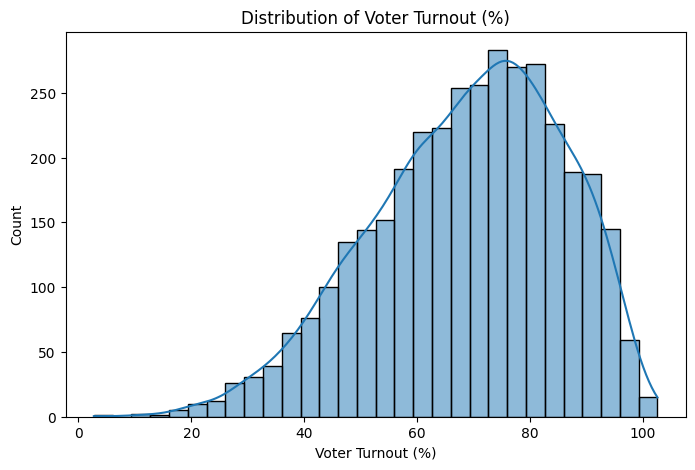

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Visualize distribution of voter turnout
# ========================
plt.figure(figsize=(8,5))
sns.histplot(cleaned_data['Voter Turnout']*100, bins=30, kde=True)
plt.title("Distribution of Voter Turnout (%)")
plt.xlabel("Voter Turnout (%)")
plt.ylabel("Count")
plt.show()

# **Feature Selection and Train-Test Split**

This cell defines the input features and target variable for the prediction task and prepares data for model training.

---

### **1. Feature Selection**
- **Input Features (X):**
  - `Year`
  - `Country`
  - `Registration`
  - `VAP Turnout`
  - `Voting age population`
  - `Compulsory Voting`
  - `Registration Ratio`
  - `Election Type`
- These variables are chosen as predictors of voter turnout.

- **Target Variable (y):**
  - `Voter Turnout` (percentage of eligible voters who participated).

---

### **2. Train-Test Split**
- Uses `train_test_split` from `sklearn.model_selection`:
  - **80% training data** for model fitting.
  - **20% testing data** for evaluating performance on unseen data.
- `random_state=42` ensures reproducibility of the split.


In [22]:
# 5. Features & Target
# ====================================
features = ['Year', 'Country', 'Registration', 'VAP Turnout', 'Voting age population',
            'Compulsory Voting', 'Registration Ratio', 'Election Type']
X = df[features]
y = df['Voter Turnout']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Preprocessing Pipeline Setup**

This cell prepares the preprocessing steps required before feeding data into machine learning models.

---

### **1. Define Feature Types**
- **Numeric Features:**
  - `Year`
  - `Registration`
  - `VAP Turnout`
  - `Voting age population`
  - `Compulsory Voting`
  - `Registration Ratio`
- **Categorical Features:**
  - `Country`
  - `Election Type`

---

### **2. Numeric Transformer**
- Uses `FunctionTransformer` with a custom lambda function:
  - Fills missing numeric values with the **median** of each column.
  - Median imputation is robust to outliers compared to mean.

---

### **3. Categorical Transformer**
- Applies `OneHotEncoder`:
  - Converts categorical variables into binary (dummy) columns.
  - `handle_unknown='ignore'` ensures unseen categories during prediction won’t cause errors.
  - `sparse_output=False` outputs a dense array for easier integration.

---

### **4. Combine Transformers**
- `ColumnTransformer` applies:
  - Numeric transformation to numeric columns.
  - Categorical encoding to categorical columns.
- Ensures all features are preprocessed correctly in a single step.


In [23]:
# 6. Preprocessing Pipeline
# ====================================
numeric_features = ['Year', 'Registration', 'VAP Turnout', 'Voting age population', 'Compulsory Voting', 'Registration Ratio']
categorical_features = ['Country', 'Election Type']

numeric_transformer = FunctionTransformer(lambda x: x.fillna(x.median()))
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# **Hyperparameter Tuning and Model Training**

This section builds and trains three regression models to predict voter turnout, using pipelines with preprocessing and grid search for optimization.

---

### **1. Baseline: Linear Regression**
- Creates a pipeline combining:
  - `pre`: Preprocessing step (numeric + categorical transformations).
  - `LinearRegression` model.
- Fits the pipeline to training data to serve as a baseline model.

---

### **2. Random Forest with Grid Search**
- Builds a pipeline with `RandomForestRegressor`.
- Defines hyperparameters to tune:
  - `n_estimators` (number of trees): [100, 200]
  - `max_depth` (tree depth): [10, 20, None]
  - `min_samples_split` (minimum samples to split): [2, 5]
- Uses **GridSearchCV** with 3-fold cross-validation and `neg_mean_absolute_error` as the scoring metric.
- Fits grid search on training data to find the best parameter combination.

---

### **3. Gradient Boosting with Grid Search**
- Builds a pipeline with `GradientBoostingRegressor`.
- Defines hyperparameters to tune:
  - `n_estimators` (number of boosting stages): [100, 200]
  - `learning_rate` (step size): [0.05, 0.1]
  - `max_depth` (depth of individual trees): [3, 5]
- Uses **GridSearchCV** with same scoring and cross-validation setup as Random Forest.
- Fits grid search on training data to identify optimal parameters.

---

**Purpose:**  
This approach ensures each model is optimized for the dataset, allowing fair comparison later when evaluating performance.


In [24]:
# 6. Hyperparameter Tuning & Model Training
# ====================================

# Baseline Linear Regression
lin_reg = Pipeline(steps=[('pre', preprocessor), ('model', LinearRegression())])
lin_reg.fit(X_train, y_train)

# Random Forest with GridSearch
rf_pipe = Pipeline(steps=[('pre', preprocessor), ('model', RandomForestRegressor(random_state=42))])
rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Gradient Boosting with GridSearch
gb_pipe = Pipeline(steps=[('pre', preprocessor), ('model', GradientBoostingRegressor(random_state=42))])
gb_params = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5],
}
gb_grid = GridSearchCV(gb_pipe, gb_params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         FunctionTransformer(func=<function <lambda> at 0x0000024A36F41580>),
                                                                         ['Year',
                                                                          'Registration',
                                                                          'VAP '
                                                                          'Turnout',
                                                                          'Voting '
                                                                          'age '
                                                                          'population',
                                                                          'Compulsory '
                                                                          'Voting',
                                                                          'Registration '
                                                                          'Ratio']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Country',
                                                                          'Election '
                                                                          'Type'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

# **9. Evaluating Model Performance**

- Uses metrics:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
  - R² score
- Compares models’ predictive accuracy on test data.
- Helps select the best performing model.



--- RandomForest Model Performance ---
R-squared (R2): 0.9771
Mean Absolute Error (MAE): 0.0095
Mean Squared Error (MSE): 0.0006
---------------------------------------


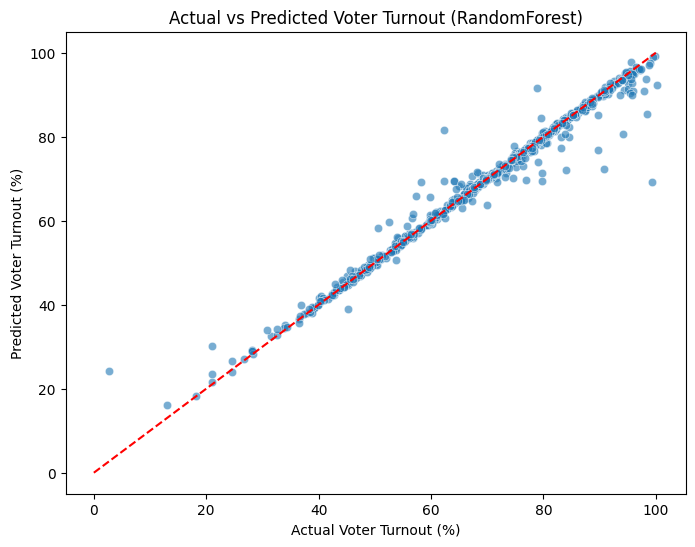

In [33]:
# 9. Plot Actual vs Predicted for Best Model
# ========================

# Select the best model based on validation score
scores = {
	"RandomForest": rf_grid.best_score_,
	"GradientBoosting": gb_grid.best_score_,
	"LinearRegression": -mean_absolute_error(y_test, lin_reg.predict(X_test))
}
best_model_name = max(scores, key=scores.get)

if best_model_name == "RandomForest":
	best_model = rf_grid.best_estimator_
elif best_model_name == "GradientBoosting":
	best_model = gb_grid.best_estimator_
else:
	best_model = lin_reg

y_pred = best_model.predict(X_test)

# --- ADD THIS CODE BELOW TO DISPLAY METRICS ---
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the metrics
print(f"--- {best_model_name} Model Performance ---")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print("---------------------------------------")
# --- END OF ADDED CODE ---


plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test*100, y=y_pred*100, alpha=0.6)
plt.plot([0,100],[0,100], color='red', linestyle='--')  # perfect prediction line
plt.title(f"Actual vs Predicted Voter Turnout ({best_model_name})")
plt.xlabel("Actual Voter Turnout (%)")
plt.ylabel("Predicted Voter Turnout (%)")
plt.show()


In [34]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming rf_grid, gb_grid, and lin_reg objects are already defined and trained from previous cells.
# Assuming X_test, y_test are also defined from train_test_split.

# --- RANDOM FOREST REGRESSOR METRICS (for completeness, you already have this) ---
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("--- Random Forest Regressor Performance ---")
print(f"R-squared (R2): {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print("---------------------------------------")

# --- GRADIENT BOOSTING REGRESSOR METRICS ---
gb_model = gb_grid.best_estimator_
y_pred_gb = gb_model.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)

print("\n--- Gradient Boosting Regressor Performance ---")
print(f"R-squared (R2): {r2_gb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_gb:.4f}")
print(f"Mean Squared Error (MSE): {mse_gb:.4f}")
print("---------------------------------------")

# --- LINEAR REGRESSION METRICS ---
lin_reg_model = lin_reg
y_pred_lr = lin_reg_model.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("\n--- Linear Regression Performance ---")
print(f"R-squared (R2): {r2_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print("---------------------------------------")

--- Random Forest Regressor Performance ---
R-squared (R2): 0.9771
Mean Absolute Error (MAE): 0.0095
Mean Squared Error (MSE): 0.0006
---------------------------------------

--- Gradient Boosting Regressor Performance ---
R-squared (R2): 0.9779
Mean Absolute Error (MAE): 0.0127
Mean Squared Error (MSE): 0.0006
---------------------------------------

--- Linear Regression Performance ---
R-squared (R2): 0.5630
Mean Absolute Error (MAE): 0.0820
Mean Squared Error (MSE): 0.0123
---------------------------------------


# **9. Evaluating Model Performance**

- Uses metrics:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
  - R² score
- Compares models’ predictive accuracy on test data.
- Helps select the best performing model.


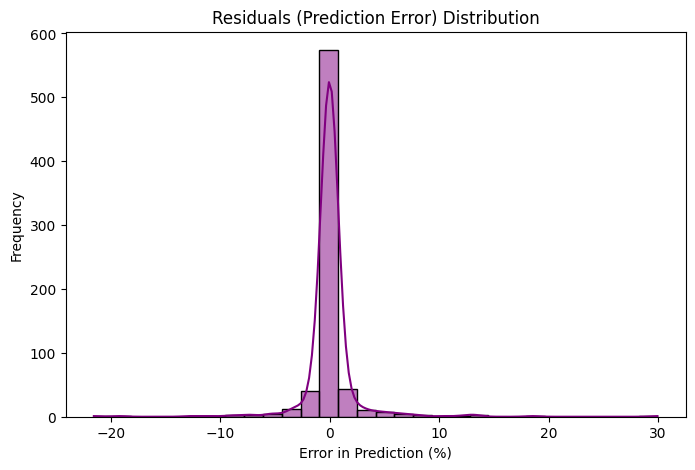

In [26]:
# 9. Plot Residuals
# ========================
residuals = (y_test - y_pred) * 100
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.title("Residuals (Prediction Error) Distribution")
plt.xlabel("Error in Prediction (%)")
plt.ylabel("Frequency")
plt.show()

# **Handling Missing Values with Median Imputation and Saving the Model**

This cell updates the preprocessing pipeline to handle missing numeric values using **median imputation**, retrains the model, and saves it.

### Key Steps:

1. **Define Median Imputation Function**
   - `fillna_median()` replaces missing values with the median of the column.

2. **Recreate Numeric Transformer**
   - Uses `FunctionTransformer` with the custom median function.
   - Ensures missing numeric values are automatically filled during preprocessing.

3. **Update Preprocessor**
   - Combines numeric and categorical transformations via `ColumnTransformer`.

4. **Refit Best Model Pipeline**
   - Replaces the preprocessing step in the existing `best_model` pipeline.
   - Retrains the model on training data with updated preprocessing.

5. **Save Trained Model**
   - Saves the updated pipeline (preprocessor + model) to `voter_turnout_model.pkl` using `joblib`.

6. **Load and Predict**
   - Demonstrates how to load the saved model and use it to predict voter turnout for new input data.


In [27]:
def fillna_median(x):
	return x.fillna(x.median())

# Recreate the numeric_transformer and pipeline with the named function
numeric_transformer = FunctionTransformer(fillna_median)
preprocessor = ColumnTransformer(transformers=[
	('num', numeric_transformer, numeric_features),
	('cat', categorical_transformer, categorical_features)
])

# Refit the best model pipeline with the new preprocessor
best_model.steps[0] = ('pre', preprocessor)
best_model.fit(X_train, y_train)

import joblib

# Save the trained best model
joblib.dump(best_model, "voter_turnout_model.pkl")
print("Model saved as voter_turnout_model.pkl")

# Later, load and use it
model = joblib.load("voter_turnout_model.pkl")

# Predict on new data
# predictions = model.predict(new_subjects)
# print(predictions * 100)  # Convert to %


Model saved as voter_turnout_model.pkl


# **Loading and Using the Trained Model for Prediction**

This cell demonstrates how to use the saved machine learning model to predict voter turnout for new data.

**Steps performed:**

1. **Load the saved model**
   - Uses `joblib.load()` to load the trained model from `voter_turnout_model.pkl`.

2. **Create new input data**
   - Constructs a small `DataFrame` representing a hypothetical election scenario.
   - Includes features like:
     - `Year`
     - `Registration`
     - `VAP Turnout` (Voting Age Population Turnout)
     - `Voting age population`
     - `Compulsory Voting` (binary: 1 = Yes, 0 = No)
     - `Election Type`

3. **Predict voter turnout**
   - Uses the loaded model’s `.predict()` method to generate a prediction.
   - Multiplies by 100 to express turnout as a percentage.

4. **Print prediction**
   - Displays the predicted voter turnout for the given scenario.


In [28]:
# Load the saved model
model = joblib.load("voter_turnout_model.pkl")

# Example test subject(s) for prediction
new_data = pd.DataFrame([
    {
        "Year": 2025,
        "Country": "Afghanistan",  # Use a country present in your training data
        "Registration": 12000000,
        "VAP Turnout": 0.65,
        "Voting age population": 20000000,
        "Compulsory Voting": 1,
        "Registration Ratio": 12000000 / 20000000,
        "Election Type": "Presidential"
    }
])

# Predict voter turnout (as float; multiply by 100 to get percentage)
predicted_turnout = model.predict(new_data)
print("Predicted turnout:", predicted_turnout[0] * 100, "%")



Predicted turnout: 71.71765 %


# **Model Performance Visualization**

This cell compares the performance of three regression models (`RandomForest`, `GradientBoosting`, and `LinearRegression`) using three metrics:

- **MAE (Mean Absolute Error)** – Lower values indicate better predictions.
- **RMSE (Root Mean Squared Error)** – Also lower is better; penalizes larger errors more than MAE.
- **R² (Coefficient of Determination)** – Higher values indicate better model fit (closer to 1 is ideal).

**Steps performed:**
1. Define lists for metrics (`mae`, `rmse`, `r2`) corresponding to each model.
2. Use `numpy.arange()` to set positions for grouped bar charts.
3. Plot three bars per model (orange, green, blue) with a width of `0.25` for clarity.
4. Customize chart:
   - Add labels, title, and legend.
   - Use `set_xticks` and `set_xticklabels` to display model names on x-axis.
5. Display the plot with `plt.show()`.

This visualization makes it easy to compare models side-by-side and identify which performs best across multiple metrics.


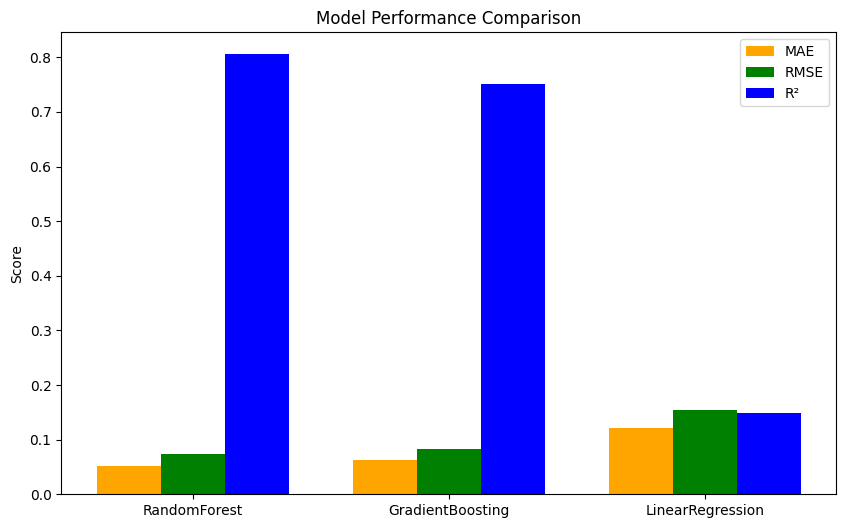

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Model results
models = ["RandomForest", "GradientBoosting", "LinearRegression"]

mae = [0.0520, 0.0632, 0.1216]
rmse = [0.0740, 0.0837, 0.1549]
r2 = [0.8055, 0.7514, 0.1483]

x = np.arange(len(models))
width = 0.25  # width of bars

fig, ax = plt.subplots(figsize=(10, 6))

# Bars for each metric
ax.bar(x - width, mae, width, label='MAE', color='orange')
ax.bar(x, rmse, width, label='RMSE', color='green')
ax.bar(x + width, r2, width, label='R²', color='blue')

# Add labels and title
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display
plt.show()


# **Exploratory Data Analysis (EDA) Summary**

This cell performs a quick overview of the cleaned voter turnout dataset:

1. **Dataset Shape**  
   - Prints the total number of rows and columns in the dataset.

2. **Missing Values**  
   - Displays how many missing values exist in each column, helping identify columns needing cleaning or imputation.

3. **Descriptive Statistics (Numeric Columns)**  
   - Summarizes numerical columns (mean, standard deviation, min, max, etc.) to understand data distribution.

4. **Categorical Summary**  
   - Shows:
     - Number of unique countries and their top 5 counts.
     - Number of unique election types and their counts.

5. **Correlation with Voter Turnout**  
   - Computes correlations between numeric features and `Voter Turnout`.
   - Helps identify variables strongly related to voter turnout (positive or negative).


In [30]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv("cleaned_voter_turnout_with_country.csv")

# 1. Shape of the dataset
print(f"Dataset Shape: {df.shape[0]} rows and {df.shape[1]} columns\n")

# 2. Missing values per column
print("Missing Values:\n", df.isnull().sum(), "\n")

# 3. Descriptive statistics for numeric columns
print("Numeric Summary:\n", df.describe(), "\n")

# 4. Categorical summary (Country and Election Type)
print("Unique Countries:", df['Country'].nunique())
print("Top 5 Countries:\n", df['Country'].value_counts().head(), "\n")

print("Unique Election Types:", df['Election Type'].nunique())
print("Election Type Counts:\n", df['Election Type'].value_counts(), "\n")

# 5. Correlation matrix (numeric features vs voter turnout)
corr = df.corr(numeric_only=True)['Voter Turnout'].sort_values(ascending=False)
print("Correlation with Voter Turnout:\n", corr)


Dataset Shape: 3589 rows and 9 columns

Missing Values:
 Year                      0
Country                   0
Registration             15
VAP Turnout              65
Voting age population    52
Compulsory Voting         0
Registration Ratio       64
Election Type             0
Voter Turnout             0
dtype: int64 

Numeric Summary:
               Year  Registration  VAP Turnout  Voting age population  \
count  3589.000000  3.574000e+03  3524.000000           3.537000e+03   
mean   1998.173865  1.642669e+07     0.655994           1.778219e+07   
std      19.887136  4.628851e+07     1.406553           4.769556e+07   
min    1945.000000  1.170000e+03     0.021400           2.664000e+03   
25%    1988.000000  1.168206e+06     0.497475           1.503740e+06   
50%    2002.000000  4.243467e+06     0.642500           4.690201e+06   
75%    2014.000000  1.281670e+07     0.765550           1.398400e+07   
max    2025.000000  9.688219e+08    64.260000           9.920110e+08   

       Co